# Arxiv Paper Classification
### Matteo Esposito

In [254]:
import numpy as np
import pandas as pd
import random, unicodedata, re
pd.options.mode.chained_assignment = None

## Preliminary

In [255]:
def load_data():
    """Loads data from hardcoded directory"""
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")
    return train, test

def split_training_set(df, ratio=0.7):
    """Splits training set into train and validation at a ratio of 70/30"""
    df.sample(frac=1)
    train = df[:int(ratio*df.shape[0])]
    validation = df[int(ratio*df.shape[0]):]
    return train, validation

In [256]:
# Data Cleanup
def clean(df, t):
    df[t] = df[t].apply(lambda x : re.sub('[0-9]', '', x))
    df[t] = df[t].apply(lambda x : re.sub('\[[^]]*\]', '', x))
    df[t] = df[t].apply(lambda x : re.sub("<$\.*?>", '', x))
    df[t] = df[t].apply(lambda x : re.sub("\n", " ", x))
    df[t] = df[t].apply(lambda x : x.lower())
    df[t] = df[t].apply(lambda x : x.strip())
    df[t] = df[t].apply(lambda x : re.sub("[^A-Za-z0-9]+", " ", x))
    
    
    # remove stop words
    stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", 
                 "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", 
                 "before", "being", "below", "between", "both", "but", "by", "can", "couldn", 
                 "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", 
                 "doing", "don", "don't", "down", "during", "each", "few", "for", "from", 
                 "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", 
                 "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", 
                 "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", 
                 "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", 
                 "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", 
                 "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", 
                 "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", 
                 "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", 
                 "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", 
                 "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", 
                 "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", 
                 "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", 
                 "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", 
                 "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", 
                 "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", 
                 "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", 
                 "what's", "when's", "where's", "who's", "why's", "would"]
    df[t] = df[t].apply(lambda text: ["".join(w) for w in text.split(" ") if w not in stopwords])
    
    # Convert list back to string
    newabs = [' '.join(map(str, abstract_list)) for abstract_list in df[t]]
    df[t] = newabs
    return df

In [257]:
%%time
train_full, test = load_data()
train, validation = split_training_set(train_full)

train = clean(train, 'Abstract')
validation = clean(validation, 'Abstract')
test = clean(test, 'Abstract')

CPU times: user 11 s, sys: 157 ms, total: 11.1 s
Wall time: 11.4 s


## Q4 - Naive Bayes Baselines

### Random Classifier

In [258]:
random_submission = pd.DataFrame({"Id": [], "Category": []})

In [259]:
random_submission['Id'] = test['Id']
random_submission['Category'] = np.random.choice(train['Category'].unique(), test.shape[0])

In [260]:
random_submission.to_csv("submissions/random.csv", index=False)

### Naive Bayes Classifier using Bag of Words

In [261]:
def load_data():
    """Loads data from hardcoded directory"""
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")
    return train, test

def split_training_set(df, ratio=0.7):
    """Splits training set into train and validation at a ratio of 70/30"""
    df.sample(frac=1)
    train = df[:int(ratio*df.shape[0])]
    validation = df[int(ratio*df.shape[0]):]
    return train, validation

In [262]:
class DataFormatter():
    def __init__(self, train, test, validation):
        self.train = train
        self.test = test
        self.validation = validation
        self.vocab = []
        
    def get_vocab(self):
        for wordstring in self.train:
            for word in wordstring.split(" "):
                if word not in self.vocab:
                    self.vocab.append(word)
        
    def create_bow(self):
        returnarrs = []
        for i, df in enumerate([self.train, self.test, self.validation]):
            X_bow = []
            for i in range(df.shape[0]):
                bow = {}
                abstract = df.iloc[i].split()

                # Initialize
                for word in self.vocab:
                    bow[word] = 0
                    
                # Populate with 1 in case where the word is in the provided test case.
                for word in abstract:
                    if word in bow.keys():
                        bow[word] = 1
                        
                X_bow.append(bow)
                
            for i in range(df.shape[0]):
                binary_abstract = X_bow[i]
                X_bow[i] = list(binary_abstract.values()) # Some sort of a conversion
                
            returnarrs.append(np.array(X_bow))
        
        return returnarrs

In [263]:
class BernoulliNB():
    def fit(self, X, y, alpha=1):
        classes = np.unique(y)
        self.n_classes = len(classes)
        self.n_features = X.shape[1]
        self.likelihoods = np.zeros((self.n_classes, self.n_features))
        for cat_idx, cat in enumerate(classes):
            examples_in_class = X[y==cat].shape[0]
            self.likelihoods[cat_idx] = (X[y==cat].sum(axis=0) + alpha*np.ones(self.n_features)) / (examples_in_class + alpha*self.n_classes)
            
    def get_posteriors(self, test_case):
        ones = np.ones((self.n_classes, self.n_features))
        return np.prod(self.likelihoods * test_case + (ones - self.likelihoods) * (ones - test_case), axis=1)
    
    def predict(self, test_case):
        return np.argmax(self.get_posteriors(test_case))
    
    def predict_matrix(self, X):
        return np.apply_along_axis(self.predict, 1, X)
    
    def error_rate(self, y_pred, y_true):
        er = round(1 - sum(y_pred == y_true)/y_pred.shape[0], 2)
        return er

In [264]:
# Format data into acceptable format (binary)
d = DataFormatter(train=train['Abstract'], test=test['Abstract'], validation=validation['Abstract'])
d.get_vocab()
table_output = d.create_bow()
train_abstracts, test_abstracts, validation_abstracts = (table_output[0], table_output[1], table_output[2])

Working on table#2

In [265]:
cat_mapping = {
    0:'astro-ph',
    1:'astro-ph.CO',
    2:'astro-ph.GA',
    3:'astro-ph.SR',
    4:'cond-mat.mes-hall',
    5:'cond-mat.mtrl-sci',
    6:'cs.LG',
    7:'gr-qc',
    8:'hep-ph',
    9:'hep-th',
    10:'math.AP',
    11:'math.CO',
    12:'physics.optics',
    13:'quant-ph',
    14:'stat.ML'
}

In [266]:
b = BernoulliNB()
alpha_errors = {}
for a in [0.01, 0.05, 0.1, 0.15, 0.3, 0.5, 1]:
    b.fit(X=train_abstracts, y=train['Category'], alpha=a)
    y_validation = b.predict_matrix(validation_abstracts)
    y_validation = np.vectorize(cat_mapping.get)(y_validation)
    alpha_errors[a] = np.mean(y_validation == validation['Category'])

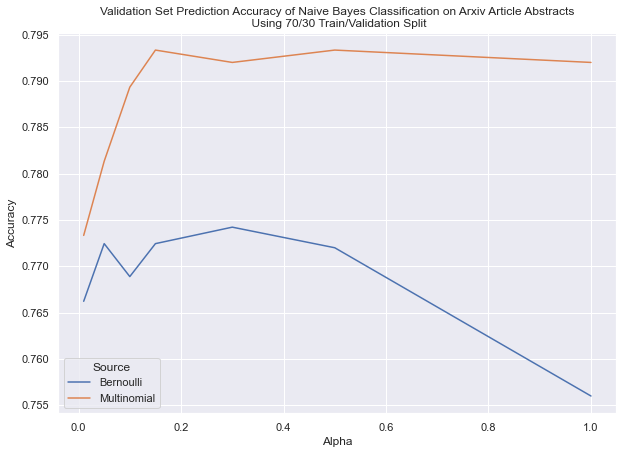

In [267]:
import seaborn as sns
import matplotlib.pyplot as plt

# Organise data into dataframes.
scores = {"Alpha": list(alpha_errors.keys()) + list(alpha_errors.keys()), 
          "Accuracy": list(alpha_errors.values()) + [0.7733333333333333, 0.7813333333333333, 0.7893333333333333, 0.7933333333333333, 0.792, 0.7933333333333333, 0.792], 
          "Source": ["Bernoulli", "Bernoulli", "Bernoulli", "Bernoulli", "Bernoulli", "Bernoulli", "Bernoulli", 
                     "Multinomial", "Multinomial", "Multinomial", "Multinomial", "Multinomial", "Multinomial", "Multinomial"]}
df = pd.DataFrame(scores)

# Generate graph
plt.figure(figsize=(10, 7))
plt.title('Validation Set Prediction Accuracy of Naive Bayes Classification on Arxiv Article Abstracts\n Using 70/30 Train/Validation Split')
sns.lineplot(x="Alpha", y="Accuracy", hue="Source", data=df)
plt.savefig('compare.png')
plt.show();

In [268]:
# Submission
ALPHASTAR = 0.3
b.fit(X=train_abstracts, y=train['Category'], alpha=ALPHASTAR)
y_test = b.predict_matrix(test_abstracts)
y_test = np.vectorize(cat_mapping.get)(y_test)

test['Category'] = y_test
test.drop(columns=["Abstract"], inplace=True)
test.to_csv("np_bernoulli_alpha_pt3_FULL.csv", index=False) ## LEADERBOARD SCORE: 0.76822 w/ 0.3 (FULL DATA: 0.77755 w/ 0.3)